
# Radar observation : rainfall composite product, quality code

The aim of this notebook is to indicate how to read the quality code data of the rainfall product.

For each pixel of the rainfall product is associated a quality code with values between 0 (very bad) and 100 (perfect), the unit is the percent. If the value is missing, then the value is 255. 

# Quickstart

In [1]:
from meteonet_toolbox.user_configuration import *
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.basemap import Basemap, cm 

In [14]:
####Cell containing the modifiable fields######
zone = "NW"
year = 2016
month = 8
decade = 3 
#min and max indexes when the dataset is loaded in memory -> it is useful if you have a small RAM 
# the maximum possible value is 3168 (1 data per 5 min at maximum for a 11 days maximal period -> 12*24*11 = 3168), with : 
# 12 : 12 data per hour (frequency = 5 min)
# 24 : 24 hours per day
# 11 : 11 days
ind_min = 0
ind_max = 15
fname_mean = "../../data_samples/radar/rainfall_mean_quality_code_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))
fname_diff = "../../data_samples/radar/rainfall_diff_quality_code_%s_%s_%s.%s.npz" % (zone, str(year),"{:02d}".format(month),str(decade))

fname_coords = "../../data_samples/radar/radar_coords_%s.npz" % (zone)

#index of the chosen 5 min of the decade for the plot with basemap (cf last cell of the notebook) 
#/!\ 0 <= ind <= ind_max-ind_min 
ind = 5

In [15]:
#coordinates of study zone boundaries
lllat=DOMAINS[zone]['lry']    #lower left latitude
urlat=DOMAINS[zone]['uly']    #upper right latitude
lllon=DOMAINS[zone]['ulx']    #lower left longitude
urlon=DOMAINS[zone]['lrx']    #upper right longitude

In [16]:
def plot_quality_code(fname_mean, fname_diff, fname_coords,ind_min,ind_max,title = "4 examples of code quality plots"):
    #data loading
    m0 = np.load(fname_mean,allow_pickle=True)
    d0 = np.load(fname_diff,allow_pickle=True)
    #subset of data 
    mean_data = m0['data']        #values of the means
    mean_dates = m0['dates']        #associated dates of the means (year, month, day)
    mean_miss_dates = m0['miss_dates'] #missing dates of the means (year, month, day)
    diff_data = d0['data'][ind_min:ind_max,:,:]    #values of the differences (= values - mean)
    dates = d0['dates'][ind_min:ind_max]    #dates of the differences (year, month, day, hour, minute)
    miss_dates = d0['miss_dates'][ind_min:ind_max]     #missing dates of the differences (year, month, day, hour, minute)

    day_i = dates[0].day
    day_f = dates[dates.shape[0]-1].day

    #compute the real values (=mean+diff)
    x = mean_data.shape[1]      #dimension in longitude
    y = mean_data.shape[2]      #dimension in latitude
    data = np.zeros((diff_data.shape[0],x,y),dtype=np.int16)     #initialisation of the array containing the original values
    d = np.asarray([dates[t].day for t in range(0,dates.shape[0])])
    m = np.asarray([mean_dates[m].day for m in range(0,mean_dates.shape[0])])
    for date in mean_dates:
        day = date.day
        if((day_i <= day) and (day <= day_f)):
            i_min = np.where(d==day)[0][0]
            i_max = np.where(d==day)[0][len(np.where(d==day)[0])-1]
            data[i_min:i_max+1,:,:] = mean_data[m==day] + diff_data[d==day]
            data[diff_data==255] = 255  #put 255 for the missing values 

    #get the coordinates of the points
    coords = np.load(fname_coords, allow_pickle=True)
    lat = coords['lats']
    lon = coords['lons']

    ######plots#####

    fig, ax = plt.subplots(2, 2,figsize=(9,9))
    fig.suptitle(title, fontsize=16)

    #colorbar definition
    cmap = colors.ListedColormap(['purple', 'deeppink', 'grey','darkturquoise', 'dodgerblue','darkviolet','olivedrab'
                                      ,'lime','orange','yellow','red'])
    bounds = [0,10,20,30,40,50,60,70,80,90,100,255]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    pl=ax[0,0].pcolormesh(lon, lat, data[0,:,:],cmap=cmap, norm=norm)
    ax[0,0].set_ylabel('latitude (degrees_north)')
    ax[0,0].set_title(str(dates[0]) + " - "+  zone + " zone")

    pl=ax[0,1].pcolormesh(lon, lat, data[1,:,:],cmap=cmap, norm=norm)
    ax[0,1].set_title(str(dates[1]) + " - "+  zone + " zone")

    pl=ax[1,0].pcolormesh(lon, lat, data[2,:,:],cmap=cmap, norm=norm)
    ax[1,0].set_xlabel('longitude (degrees_east)')
    ax[1,0].set_ylabel('latitude (degrees_north)')
    ax[1,0].set_title(str(dates[2]) + " - "+  zone + " zone")

    pl=ax[1,1].pcolormesh(lon, lat, data[3,:,:],cmap=cmap, norm=norm)
    ax[1,1].set_xlabel('longitude (degrees_east)')
    ax[1,1].set_title(str(dates[3]) + " - "+  zone + " zone")

    cbar = fig.colorbar(pl,ax=ax.ravel().tolist(),cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'vertical').set_label('Quality code (in %) / '+ 
                                                                                                                  str(255) +' : missing values')
    plt.show()
    return data, dates, miss_dates, mean_data, mean_dates, mean_miss_dates, lat, lon

<IPython.core.display.Javascript object>


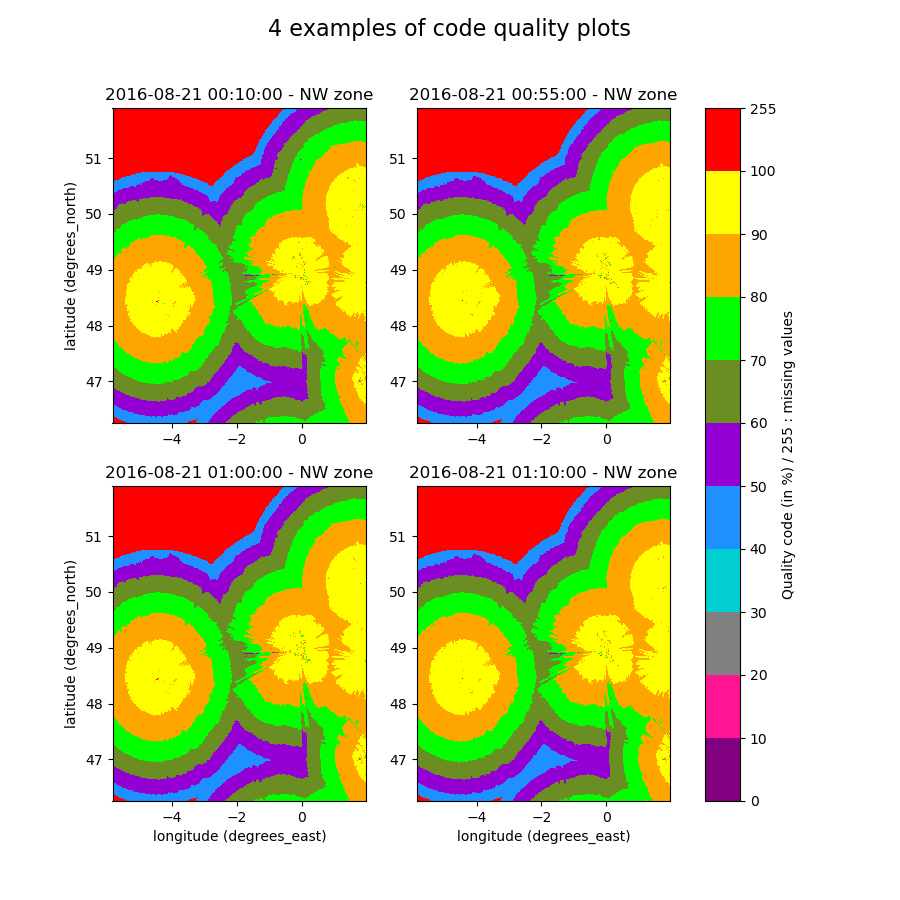

In [17]:
data, dates, miss_dates, mean_data, mean_dates, mean_miss_dates, lat, lon = plot_quality_code(fname_mean, fname_diff, fname_coords,ind_min,ind_max)

# More details

These quality code data are stored per period of 10 or 11 days per geographic zone (each month is separated in 3 files). The zones called 'NW' (for North-West of France) and 'SE' (for South-East of France).

The time step is 5 min (per day, start hour :00h and end hour : 23h55), the spatial resolution, 0.01° (the projection system is EPSG:4326).
The original data are too heavy so the quality code data are divided into 2 files : 
<ul>
    <li>1 file containing the mean of the quality code per day and per pixel (example file : rainfall_mean_quality_...npz)</li>
    <li>1 file containing the difference between the original value and the mean per pixel (example file : rainfall_diff_quality_...npz) </li>
</ul>

The min and max indexes defined in the second cell (allow to load just take a piece of data if you have a small RAM) apply only to the difference data (and not to the mean dataset). 

The missing values are also 255.

Each file (mean or diff values), contains 3 data categories : 
<ul>
    <li>'data' : quality code values </li>
    <li>'dates' : the associated dates to the quality code values (at day precision for the means and at minute precision for the differences)</li>
    <li>'miss_dates' : the dates for which the data are missing (at day precision for the means and at minute precision for the differences)</li>
</ul>

Remark about the mean computing : if there is no value for 1 day and 1 pixel, it will be indicated as a missing value, else the mean computing is done over the non missing values for 1 day and 1 pixel.

**To get the coordinates (lat,lon) of the points :**
One npz file contains 2 arrays : one for the latitudes and one for the longitudes.

Mean data dimensions:

<ul>
<li>time dimension (=days number for which there are data)</li>
<li>points number for longitude</li>
<li>points number for latitude</li>
</ul>   

In [64]:
mean_data.shape

(10, 565, 784)

Dimensions of the 'dates' array of the means:
<ul>
    <li>time dimension(=days number for which there are data)</li>
</ul>

In [65]:
mean_dates.shape

(10,)

Dimensions of the 'miss_dates' array of the means:
<ul>
    <li>time dimension(=days number for which there are no data)</li>
</ul>

In [66]:
mean_miss_dates.shape

(0,)

Overview of mean values of type int16 :

In [43]:
mean_data

array([[[255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  63,  63,  63],
        ...,
        [255, 255, 255, ...,  85,  85,  85],
        [255, 255, 255, ...,  85,  85,  85],
        [255, 255, 255, ...,  85,  85,  85]],

       [[255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  63,  63,  63],
        ...,
        [255, 255, 255, ...,  85,  85,  85],
        [255, 255, 255, ...,  85,  85,  85],
        [255, 255, 255, ...,  85,  85,  85]],

       [[255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  63,  63,  63],
        ...,
        [255, 255, 255, ...,  79,  79,  79],
        [255, 255, 255, ...,  85,  85,  85],
        [255, 255, 255, ...,  85,  85,  85]],

       [[255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  62,  62,  62],
        [255, 255, 255, ...,  63,  63,  63],
        ..

Overview of mean_dates of type datetime.datetime:

In [44]:
mean_dates

array([datetime.date(2016, 8, 21), datetime.date(2016, 8, 28),
       datetime.date(2016, 8, 30), datetime.date(2016, 8, 31)],
      dtype=object)

Dimensions of the 'data' array for the data: 
<ul>
<li>time dimension (number of 5 min records) -> can be reduced and determined by min and max indexes when the dataset is loaded in memory (cf second cell) </li> 
<li>points number for longitude</li>
<li>points number for latitude</li>
</ul>    

In [67]:
data.shape

(2880, 565, 784)

Dimensions of the 'dates' array for the data:
<ul>
    <li>time dimension (number of 5 min records for which there are data) -> can be reduced and determined by min and max indexes when the dataset is loaded in memory (cf second cell)</li>
</ul>

In [68]:
dates.shape

(2880,)

Dimensions of the 'miss_dates' array for the data:
<ul>
    <li>time dimension (number of 5 min records for which there are no data) -> can be reduced and determined by min and max indexes when the dataset is loaded in memory (cf second cell) </li>
</ul>

In [47]:
miss_dates.shape

(15,)

Overview of the missing dates for the data:

In [48]:
miss_dates

array([datetime.datetime(2016, 8, 21, 0, 0),
       datetime.datetime(2016, 8, 21, 0, 5),
       datetime.datetime(2016, 8, 21, 0, 15),
       datetime.datetime(2016, 8, 21, 0, 20),
       datetime.datetime(2016, 8, 21, 0, 25),
       datetime.datetime(2016, 8, 21, 0, 30),
       datetime.datetime(2016, 8, 21, 0, 35),
       datetime.datetime(2016, 8, 21, 0, 40),
       datetime.datetime(2016, 8, 21, 0, 45),
       datetime.datetime(2016, 8, 21, 0, 50),
       datetime.datetime(2016, 8, 21, 1, 5),
       datetime.datetime(2016, 8, 21, 1, 15),
       datetime.datetime(2016, 8, 21, 1, 20),
       datetime.datetime(2016, 8, 21, 1, 40),
       datetime.datetime(2016, 8, 21, 1, 45)], dtype=object)

Overview of longitudes:

In [49]:
lon

array([[-5.842, -5.832, -5.822, ...,  1.968,  1.978,  1.988],
       [-5.842, -5.832, -5.822, ...,  1.968,  1.978,  1.988],
       [-5.842, -5.832, -5.822, ...,  1.968,  1.978,  1.988],
       ...,
       [-5.842, -5.832, -5.822, ...,  1.968,  1.978,  1.988],
       [-5.842, -5.832, -5.822, ...,  1.968,  1.978,  1.988],
       [-5.842, -5.832, -5.822, ...,  1.968,  1.978,  1.988]])

# Nice view using Basemap

Plot the quality code values for 1 given time step

In [50]:
def plot_quality_code_with_basemap(ind,data,dates,zone):
    fig,ax=plt.subplots(1,1,figsize=(10,12))

    #background map definition : coordinates of corners, resolution, projection type
    m1 = Basemap(epsg=n_epsg,resolution='h', # You can change the resolution of the contours here
                 llcrnrlat=lllat,
                      urcrnrlat=urlat,
                      llcrnrlon=lllon,
                      urcrnrlon=urlon)

    #colorbar definition
    cmap = colors.ListedColormap(['purple', 'deeppink', 'grey','darkturquoise', 'dodgerblue','darkviolet','olivedrab'
                                      ,'lime','orange','yellow','red'])
    #cmap.set_bad(color="red")
    bounds = [0,10,20,30,40,50,60,70,80,90,100,255]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    #plot the data and the background map (coastlines and borders)
    m1.drawcoastlines()
    m1.drawcountries()
    img=m1.imshow(data[ind,:,:], interpolation='none', origin='upper',
                        cmap=cmap, norm=norm)
    plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds, orientation= 'horizontal').set_label('Quality code (in %) / '+ 
                                                                                                                  str(255) +' : missing values')
    plt.title("Quality code of the rainfalls - "+ str(dates[ind]) + " - "+ zone + " zone")
    plt.show()

<IPython.core.display.Javascript object>


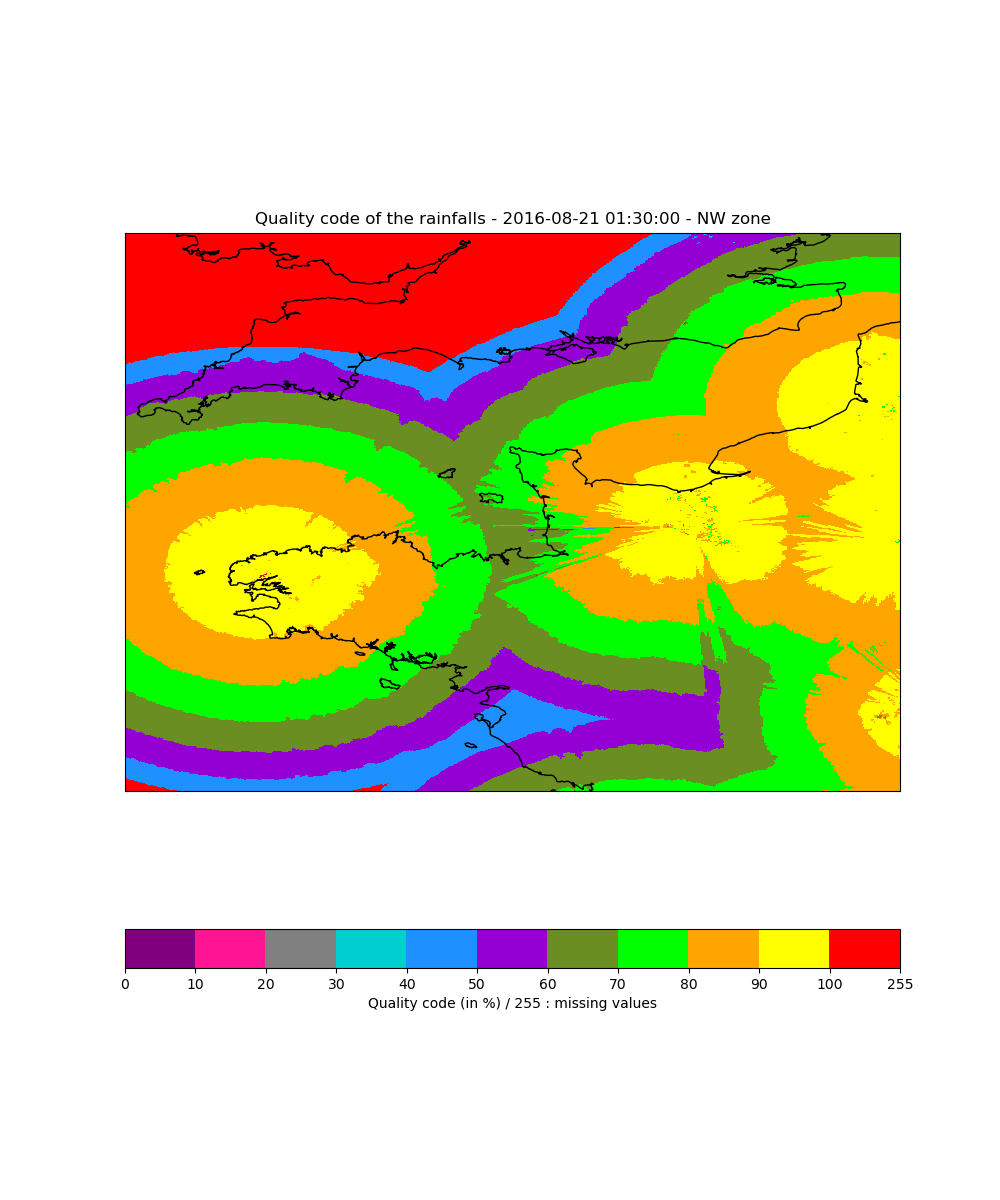

C:\Users\larvorg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\larvorg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [51]:
plot_quality_code_with_basemap(ind,data,dates,zone)

In [ ]:
m0.fid.close()
d0.fid.close()